In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from jsbsim_utils import Logger, trim, simulate

Nonlinear-dynamics of aircraft

$$\dot{x} = f(x, u)$$

Find equilibrium:

Minimize $\dot{x}$, or a subset for your problem, by changeing $x_0$, $u_0$

$$0 = f(x_0, u_0)$$

This is an optimization problem.

* Matlab: fmincon, fminsearch
* Python: scipy.minimize (Nelder-Mead, SLSQP)

Can simplify this problem with mixing matrices, to decouple the dynamcis into SISO (single-input-single output) systems.

Due to Taylor series error on the order of (dx^2). We know the linear model approx, does well near the equilibrium point. 

$\dot{\vec{x}} = \vec{f}(x, u) = A \vec{x} + B \vec{u}$

$\dot{\vec{y}} = C \vec{x} + D \vec{u}$


$A = \dfrac{\delta \vec{f}(x0, u0)}{\delta \vec{x}}$

$B = \dfrac{\delta \vec{f}(x0, u0)}{\delta \vec{u}}$

$C = \dfrac{\delta \vec{y}(x0, u0)}{\delta \vec{x}}$

$D = \dfrac{\delta \vec{y}(x0, u0)}{\delta \vec{u}}$

In [16]:
op_ground, fdm = trim(
    aircraft='F-35B-2',
    ic={
        'ic/vt-fps': 0,
        'gear/gear-cmd-norm': 1,
        'propulsion/engine/pitch-angle-rad': np.deg2rad(0),
        'fcs/throttle-cmd-norm': 0,
        'fcs/aileron-cmd-norm': 0,
        'fcs/elevator-cmd-norm': 0,
        'fcs/rudder-cmd-norm': 0,
        'fcs/left-brake-cmd-norm': 1,
        'fcs/right-brake-cmd-norm': 1,
        'fcs/center-brake-cmd-norm': 1,
    },
    design_vector=['ic/theta-rad', 'ic/h-agl-ft'],
    x0=[0, 0],
    verbose=True,
    method='Nelder-Mead', # works better with ground interaction
    tol=1e-12,
)
op_ground

 final_simplex: (array([[-0.89200304, 14.38633472],
       [-0.9093008 , 14.52117363],
       [-0.88533202, 14.33803293]]), array([21.30021981, 21.58369996, 21.84722078]))
           fun: 21.300219810897268
       message: 'Maximum number of function evaluations has been exceeded.'
          nfev: 400
           nit: 208
        status: 1
       success: False
             x: array([-0.89200304, 14.38633472])


{'ic/vt-fps': 0,
 'gear/gear-cmd-norm': 1,
 'propulsion/engine/pitch-angle-rad': 0.0,
 'fcs/throttle-cmd-norm': 0,
 'fcs/aileron-cmd-norm': 0,
 'fcs/elevator-cmd-norm': 0,
 'fcs/rudder-cmd-norm': 0,
 'fcs/left-brake-cmd-norm': 1,
 'fcs/right-brake-cmd-norm': 1,
 'fcs/center-brake-cmd-norm': 1,
 'ic/theta-rad': -0.8920030404611994,
 'ic/h-agl-ft': 14.386334723972261}

In [17]:
log_ground = simulate(
    aircraft='F-35B-2',
    op_0=op_ground,
    tf=5,
    realtime=True)

In [18]:
fdm.resume_integration()
fdm.get_propulsion().get_steady_state()

False

<AxesSubplot:xlabel='t, sec'>

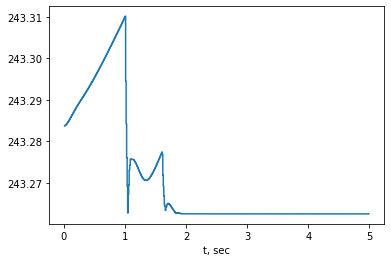

In [19]:
log_ground['propulsion/engine/thrust-lbs'].plot()

In [20]:
op_hover, fdm = trim(
    aircraft='F-35B-2',
    ic={
        'ic/h-agl-ft': 10,
        'ic/vd-fps': 0,
        'ic/vn-fps': 0*np.cos(np.deg2rad(280)),
        'ic/ve-fps': 0*np.sin(np.deg2rad(280)),
        'ic/theta-rad': 0,
        'gear/gear-cmd-norm': 1,
        'fcs/left-brake-cmd-norm': 0,
        'fcs/right-brake-cmd-norm': 0,
        'fcs/center-brake-cmd-norm': 0,
    },
    design_vector=[
        'fcs/throttle-cmd-norm',
        'fcs/elevator-cmd-norm',
        'propulsion/engine/pitch-angle-rad',
    ],
    x0=[0.1, 0, np.deg2rad(90)],
    verbose=True,
    bounds=[[0, 1], [-1, 1], [np.deg2rad(0), np.deg2rad(120)]],
    tol=1e-12
)
op_hover

      fun: 976.4705561431693
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([2.27373676e-05, 1.13686838e-05, 4.54747354e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 52
      nit: 8
     njev: 13
   status: 0
  success: True
        x: array([0.44612729, 0.46852354, 1.91095945])


{'ic/h-agl-ft': 10,
 'ic/vd-fps': 0,
 'ic/vn-fps': 0.0,
 'ic/ve-fps': -0.0,
 'ic/theta-rad': 0,
 'gear/gear-cmd-norm': 1,
 'fcs/left-brake-cmd-norm': 0,
 'fcs/right-brake-cmd-norm': 0,
 'fcs/center-brake-cmd-norm': 0,
 'fcs/throttle-cmd-norm': 0.44612729312582533,
 'fcs/elevator-cmd-norm': 0.46852353939035263,
 'propulsion/engine/pitch-angle-rad': 1.910959451285114}

In [21]:
log_hover = simulate(
    aircraft='F-35B-2',
    op_0=op_hover,
    tf=5,
    realtime=True)

In [28]:
def cost_cruise(fdm):
    # modify cost to also penalize throttle
    delta = fdm['propulsion/engine/pitch-angle-rad']
    theta = fdm['attitude/theta-rad']
    drag = fdm['forces/fwx-aero-lbs']
    lift = fdm['forces/fwz-aero-lbs']
    alpha = fdm['aero/alpha-rad']
    throttle = fdm['fcs/throttle-cmd-norm']
    
    udot = fdm['accelerations/udot-ft_sec2']
    vdot = fdm['accelerations/vdot-ft_sec2']
    wdot = fdm['accelerations/wdot-ft_sec2']
    pdot = fdm['accelerations/pdot-rad_sec2']
    qdot = fdm['accelerations/qdot-rad_sec2']
    rdot = fdm['accelerations/rdot-rad_sec2']
    return udot**2 + vdot**2 + wdot**2 + pdot**2 + qdot**2 + rdot**2 - 1e-3*(lift/drag)**2 + 1e-3*(theta < 0) + 1e-3*throttle**2
        
op_cruise, fdm = trim(
    aircraft='F-35B-2',
    ic={
        'ic/gamma-rad': 0,
        'ic/vt-fps': 677,
        'ic/h-agl-ft': 38*1e3,
        'gear/gear-cmd-norm': 0,
        'fcs/left-brake-cmd-norm': 0,
        'fcs/right-brake-cmd-norm': 0,
        'fcs/center-brake-cmd-norm': 0,
        #'propulsion/engine/pitch-angle-rad': 0,
    },
    design_vector=[
        'fcs/throttle-cmd-norm',
        'fcs/elevator-cmd-norm',
        'fcs/rudder-cmd-norm',
        'fcs/aileron-cmd-norm',
        'ic/alpha-rad',
        'ic/beta-rad',
        'propulsion/engine/pitch-angle-rad',
    ],
    cost=cost_cruise,
    x0=[0.7, 0, 0, 0, 0, 0, 0],
    verbose=True,
    bounds=[[0, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [np.deg2rad(0), np.deg2rad(120)]],
    tol=1e-12,
)
op_cruise

      fun: 4.698940937118183
 hess_inv: <7x7 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 3.28626015e-06,  2.47801779e-05, -2.68229883e-05,  7.08766379e-05,
        9.34186062e-04,  6.43041176e-05, -3.01918350e+00])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 624
      nit: 64
     njev: 78
   status: 0
  success: True
        x: array([ 0.00000000e+00, -1.15930582e-01,  7.16841251e-03, -6.76083469e-03,
        1.88649149e-02,  1.87562123e-03,  2.09439510e+00])


{'ic/gamma-rad': 0,
 'ic/vt-fps': 677,
 'ic/h-agl-ft': 38000.0,
 'gear/gear-cmd-norm': 0,
 'fcs/left-brake-cmd-norm': 0,
 'fcs/right-brake-cmd-norm': 0,
 'fcs/center-brake-cmd-norm': 0,
 'fcs/throttle-cmd-norm': 0.0,
 'fcs/elevator-cmd-norm': -0.11593058178464309,
 'fcs/rudder-cmd-norm': 0.007168412508102859,
 'fcs/aileron-cmd-norm': -0.006760834685661168,
 'ic/alpha-rad': 0.018864914912983623,
 'ic/beta-rad': 0.0018756212269339949,
 'propulsion/engine/pitch-angle-rad': 2.0943951023931953}

In [30]:
log_cruise = simulate(
    aircraft='F-35B-2',
    op_0=op_cruise,
    tf=10,
    realtime=True)